In [ ]:
%%capture
!pip install supertree

In [ ]:
import numpy as np
import pandas as pd

import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from supertree import SuperTree

from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.datasets import load_breast_cancer, make_classification, load_iris, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

## Логистическая регрессия

In [ ]:
X, y =  load_breast_cancer(return_X_y=True, as_frame=True)
y = 1 - y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.3)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
311,14.61,15.69,92.68,664.9,0.07618,0.03515,0.01447,0.01877,0.1632,0.05255,...,16.46,21.75,103.70,840.8,0.1011,0.07087,0.04746,0.05813,0.2530,0.05695
188,11.81,17.39,75.27,428.9,0.10070,0.05562,0.02353,0.01553,0.1718,0.05780,...,12.57,26.48,79.57,489.5,0.1356,0.10000,0.08803,0.04306,0.3200,0.06576
377,13.46,28.21,85.89,562.1,0.07517,0.04726,0.01271,0.01117,0.1421,0.05763,...,14.69,35.63,97.11,680.6,0.1108,0.14570,0.07934,0.05781,0.2694,0.07061
250,20.94,23.56,138.90,1364.0,0.10070,0.16060,0.27120,0.13100,0.2205,0.05898,...,25.58,27.00,165.30,2010.0,0.1211,0.31720,0.69910,0.21050,0.3126,0.07849
252,19.73,19.82,130.70,1206.0,0.10620,0.18490,0.24170,0.09740,0.1733,0.06697,...,25.28,25.59,159.80,1933.0,0.1710,0.59550,0.84890,0.25070,0.2749,0.12970


### Мотивация

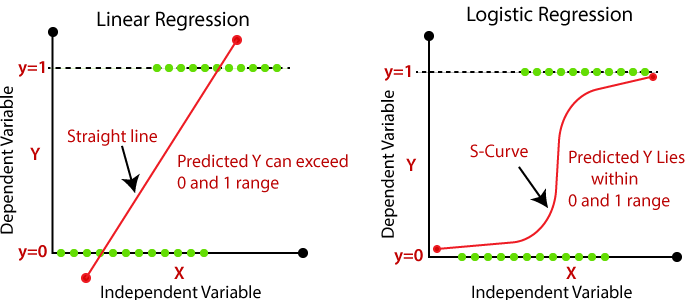

Мы можем рассматривать задачу бинарной классификации как задачу предсказания вероятности события класса 1.

Для решения этой задачи можно научить линейную модель правильно предсказывать какой-то объект, связанный с вероятностью, но с диапазоном значений ***R***, и преобразовать ответы модели в вероятность.


#### Какой объект связан с вероятностью по смыслу и имеет область значений ***R***?



**Шанс** - отношение вероятности, что событие произойдет, к вероятности, что оно не произойдет - $odds = \frac{P_i}{1-P_i}$

Прологаририфмировав шансы можно перейти в область значений ***R*** к логитам.

$logit = log(\frac{P_i}{1-P_i})$

Также результат такого преобразования симметричен относительно точки 0.5

И небольшие изменения вероятностей приводят к большим изменениям логитов, когда вероятности находятся вблизи 0 и 1

=> давайте предсказывать логиты!

$logit = log(\frac{P_i}{1-P_i}) = b_0 + b_1x_1 + ... + b_nx_n$


В итоге получается, что несмотря на класс "линейные модели" логистическая регрессия линейно оценивает логарифмы шансов, а связь с самими вероятностями нелинейна

#### Как перейти от логитов к вероятностям?




* Используем преобразование, обратное логарифму для получения шансов:


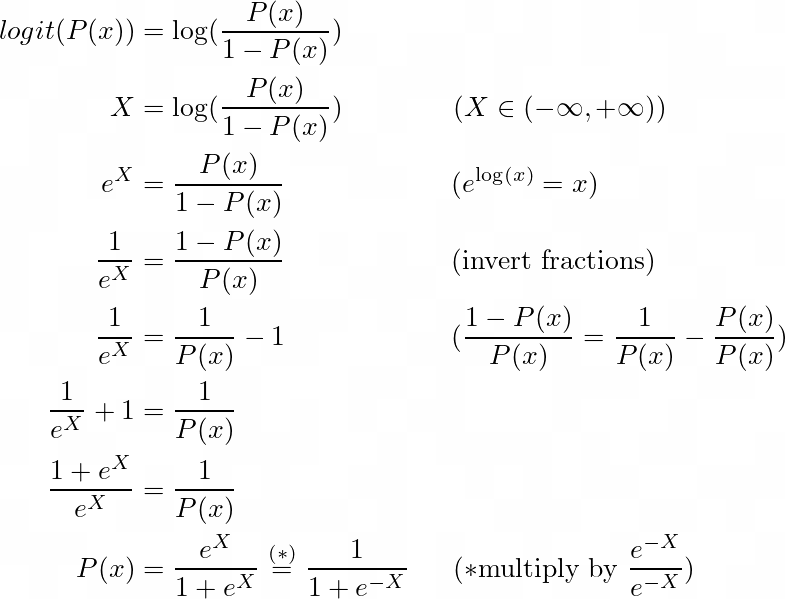

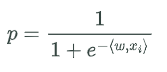

#### А какая функция потерь?



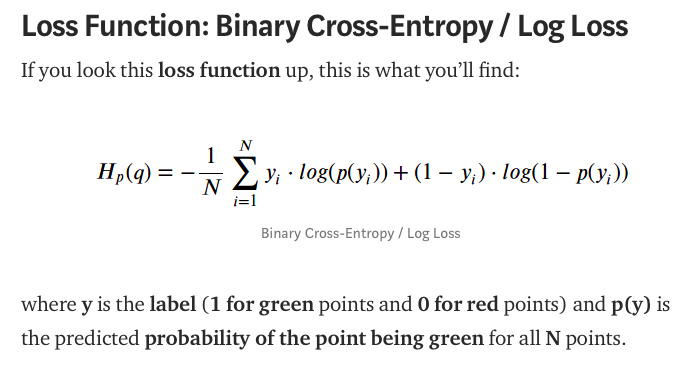

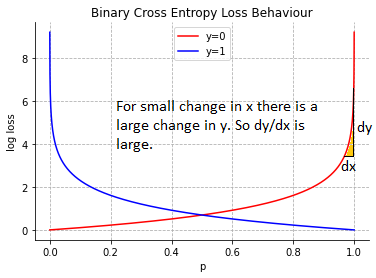

### Обучим модель из sklearn

In [ ]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_preds_logreg = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_preds_logreg))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       110
           1       0.98      0.97      0.98        61

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



### Многоклассовый случай

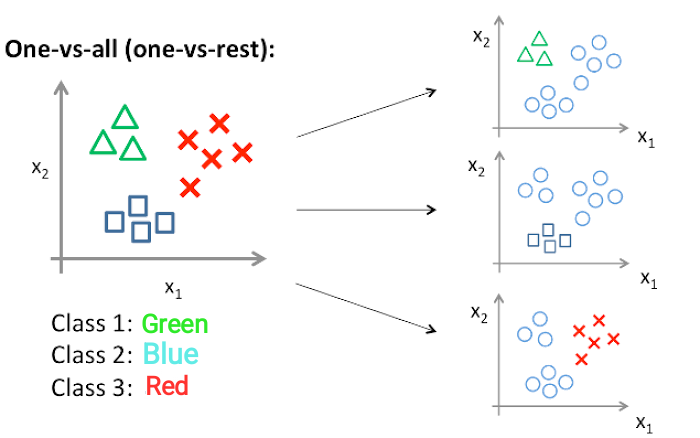

Также есть подход **One-vs-One**

In [ ]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=4, random_state=2023)
model = LogisticRegression(multi_class='ovr')
model.fit(X, y)
y_preds_ovr = model.predict(X)
print(classification_report(y, y_preds_ovr))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62       251
           1       0.65      0.71      0.68       251
           2       0.71      0.76      0.73       250
           3       0.65      0.64      0.65       248

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



## Метод k-ближайших соседей (kNN)

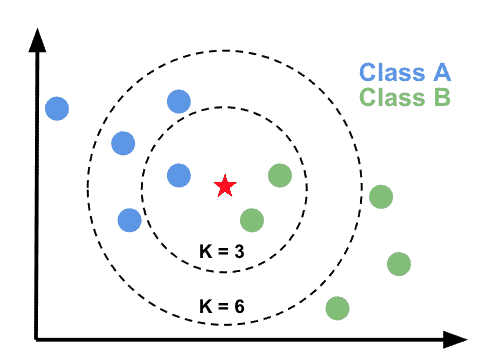

Перед применением необходима нормализация

#### Breast cancer

weights:

`uniform`: все точки взвешиваются одинаково

`distance`: вес обратен расстоянию: более близкие точки имеют большее "влияние"

In [ ]:
X, y =  load_breast_cancer(return_X_y=True, as_frame=True)
y = 1 - y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.3)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
y_preds_knn = knn.predict(X_test)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       110
           1       0.95      0.92      0.93        61

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



#### Visualization

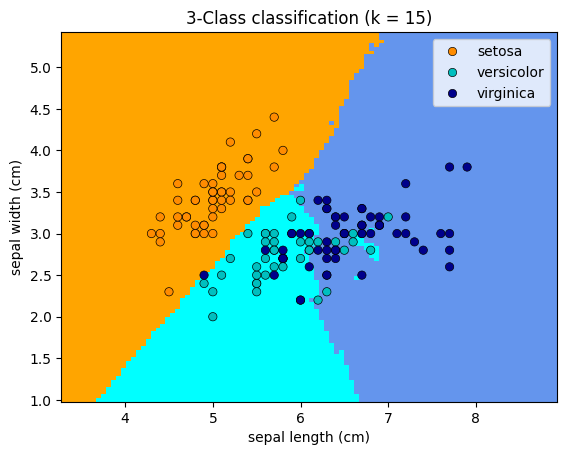

In [ ]:
n_neighbors = 15

iris = load_iris()

X = iris.data[:, :2]
y = iris.target

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

clf = KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X, y)

_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel=iris.feature_names[0],
    ylabel=iris.feature_names[1],
    shading="auto",
)

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=iris.target_names[y],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(f"3-Class classification (k = {n_neighbors})")

plt.show()

## Деревья решений

[Давайте поиграем?](https://ru.akinator.com/)

### Идея

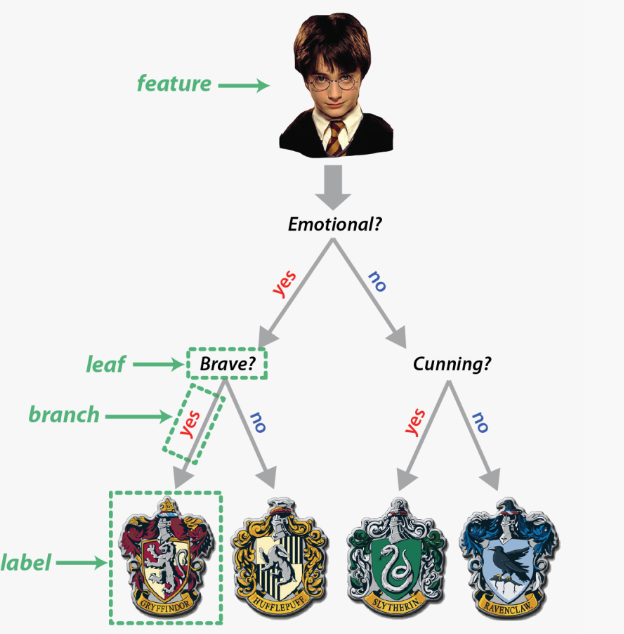

### Дерево для классификации из sklearn

In [ ]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_preds = clf.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



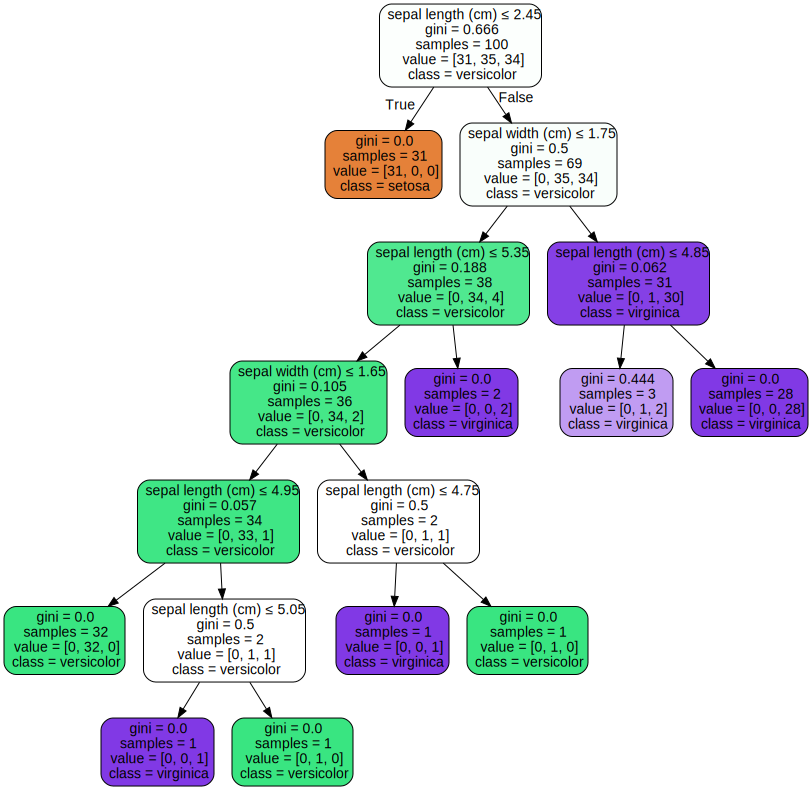

In [ ]:
dot_data = export_graphviz(
  clf, out_file=None,
  feature_names=iris.feature_names[:2],
  class_names=iris.target_names,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(dot_data)
graph

In [ ]:
super_tree = SuperTree(clf, X_train, y_train, iris.feature_names, iris.target_names)
super_tree.show_tree()

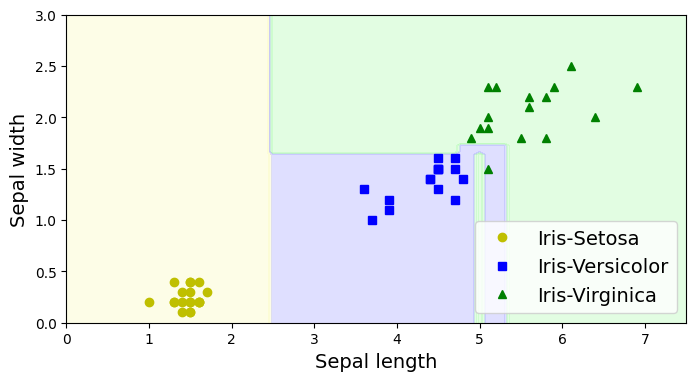

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Sepal length", fontsize=14)
        plt.ylabel("Sepal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(clf, X_test, y_test, legend=True)
plt.show()

### Верхнеуровневый процесс построения

- Процесс построения деревьев решений заключается в последовательном, **рекурсивном разбиении** обучающего множества на подмножества с применением **решающих правил** (предикатов) в узлах.
- Процесс разбиения продолжается до тех пор, пока все узлы в конце всех ветвей не будут объявлены листьями. Объявление узла листом может произойти **естественным образом**, или по достижении **некоторого условия остановки**, задаваемого пользователем
- Алгоритмы построения деревьев решений относят к категории так называемых **жадных** алгоритмов. Жадными называются алгоритмы, которые допускают, что локально-оптимальные решения на каждом шаге (разбиения в узлах), приводят к оптимальному итоговому решению – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается **наибольшим**.


[Как создать идеальное дерево решений: для начинающих аналитиков данных и не только](https://cloud.vk.com/blog/kak-sozdat-idealnoe-derevo-reshenij)

#### Как выбрать предикат?

При построении дерева необходимо задать функционал качества, на основе которого осуществляется разбиение выборки на каждом шаге.

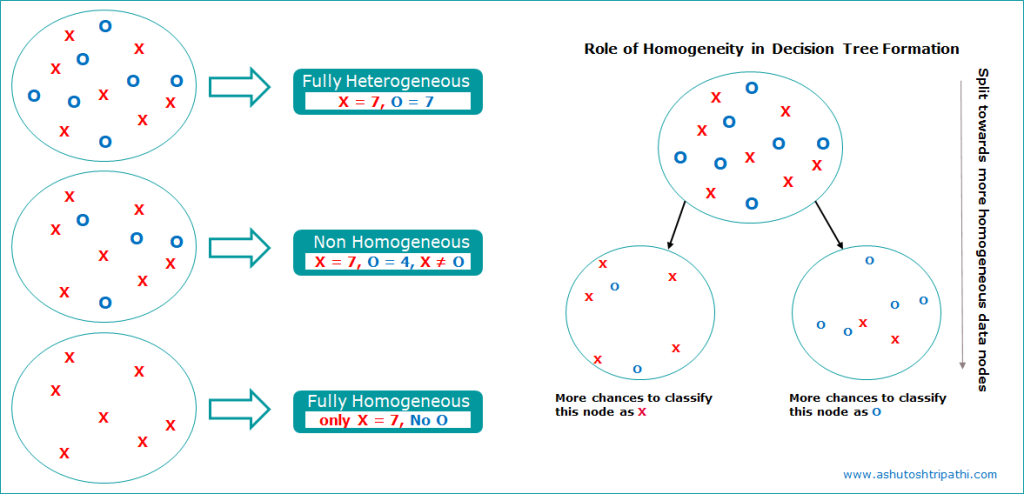

* Для регрессии можно взять дисперсию таргета или любые другие отклонения
* Для классификации - энтропию или Джини (максимизация числа пар объектов одного класса, оказавшихся в одном поддереве)



[Death Note, анонимность и энтропия](https://habr.com/ru/articles/516190/)

In [ ]:
clf.predict_proba([[5, 1.5]])

array([[0., 0., 1.]])

In [ ]:
clf.predict([[5, 1.5]])

array([2])

In [ ]:
clf

DecisionTreeClassifier()

### Классификация - make_moons

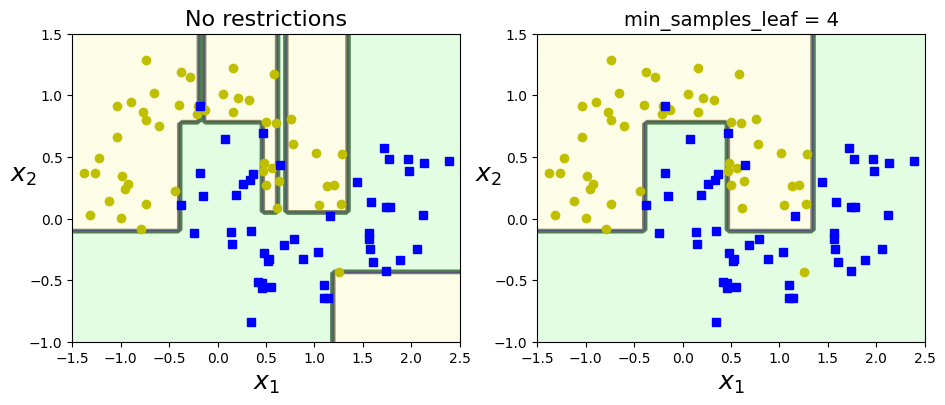

In [ ]:
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.show()

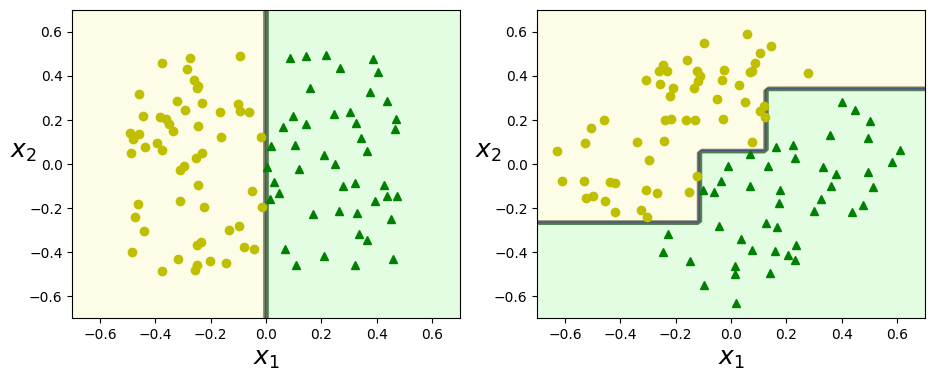

In [ ]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.show()

### Регрессия

In [ ]:
np.random.seed(42)

m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [ ]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

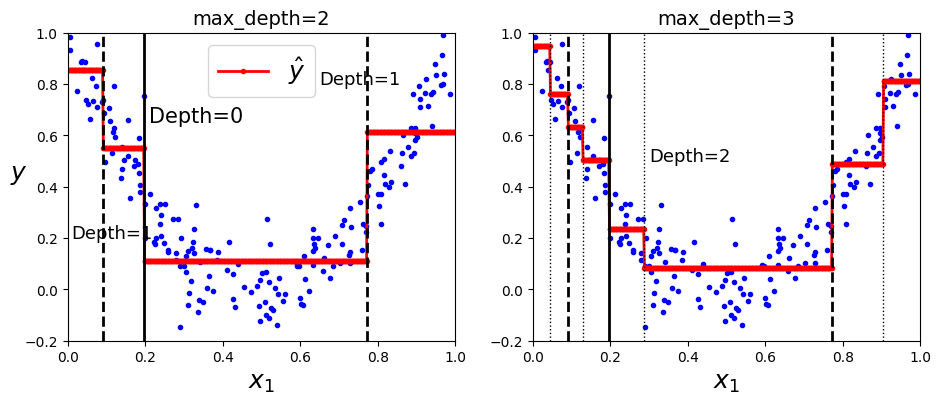

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)

for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)

plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)

for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)

plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

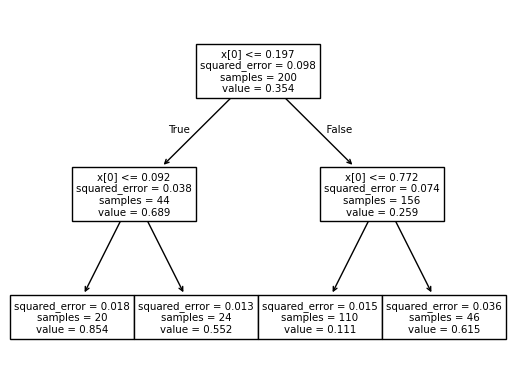

In [ ]:
plot_tree(tree_reg1)
plt.show()

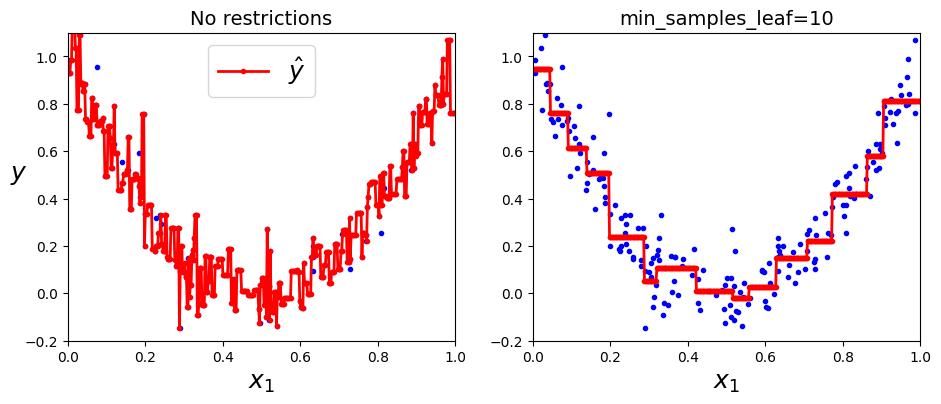

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)
plt.show()

Дерево решений способно идеально приблизить обучающую выборку и ничего не выучить (то есть такой классификатор будет обладать низкой обобщающей способностью): для этого достаточно построить такое дерево, в каждый лист которого будет попадать только один объект.